In [1]:
import torch, sys, yaml, pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO
import random, shutil   

print("Python:", sys.version)
print("Torch:", torch.__version__, "| CUDA available?", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

from pathlib import Path
DATA_ROOT = Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v1") 
DATA_YAML = DATA_ROOT / "data.yaml"

for p in ["train/images","train/labels","valid/images","valid/labels","test/images","test/labels"]:
    d = DATA_ROOT / p
    print(f"{p:>20} -> {d.exists()} ({len(list(d.glob('*')))} files)")

SUPPORTED_IMG_EXTS = {
    "webp","jpeg","tiff","dng","jpg","bmp","heic","png","tif","mpo","pfm"
}

Python: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Torch: 2.3.1+cu121 | CUDA available? True
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
        train/images -> True (240 files)
        train/labels -> True (240 files)
        valid/images -> True (60 files)
        valid/labels -> True (60 files)
         test/images -> False (0 files)
         test/labels -> False (0 files)


In [2]:
model = YOLO("yolov8s.pt")
results = model.train(
    data=str(DATA_YAML),
    imgsz=896,          # YOLO resizes+letterboxes on the fly
    rect=True,          # rectangular batches -> less padding, faster
    epochs=150,
    batch=8,
    cache="ram",
    device=0,
    workers=2,
    # augmentations (balanced for exercise detection)
    fliplr=0.5, flipud=0.0,
    degrees=7.0, translate=0.04, scale=0.5, shear=3.0, perspective=0.0,
    mosaic=0.15, mixup=0.0, copy_paste=0.0,
    close_mosaic=10,
    optimizer="AdamW",
    cos_lr=True, lr0=0.004, patience=30,
    project="runs", name="exercise_v1"
)

New https://pypi.org/project/ultralytics/8.3.226 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v1\data.yaml, degrees=7.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=896, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.004, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, 

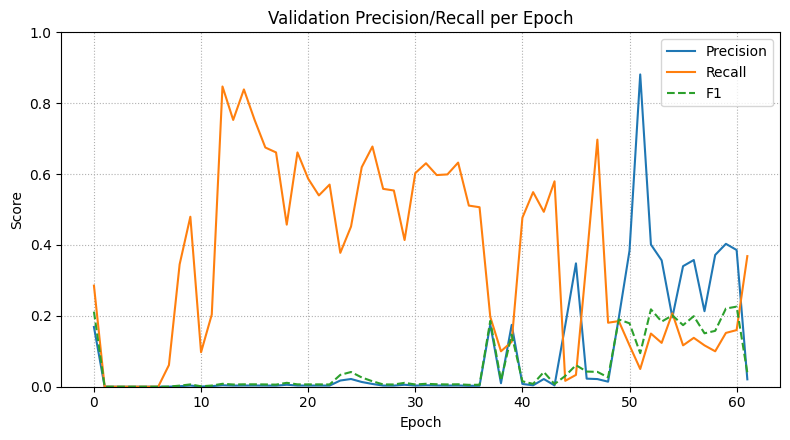

In [ ]:
%matplotlib inline
run_dir = Path(results.save_dir)  # e.g. runs/detect/exercise_v1
df = pd.read_csv(run_dir / "results.csv")

p_col = next(c for c in df.columns if "metrics/precision" in c)  # 'metrics/precision(B)'
r_col = next(c for c in df.columns if "metrics/recall" in c)     # 'metrics/recall(B)'

epochs = np.arange(len(df))
p = df[p_col].astype(float)
r = df[r_col].astype(float)
f1 = (2 * p * r / (p + r).replace(0, np.nan)).fillna(0.0)

fig = plt.figure(figsize=(8, 4.5))
plt.plot(epochs, p, label="Precision")
plt.plot(epochs, r, label="Recall")
plt.plot(epochs, f1, linestyle="--", label="F1")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.ylim(0, 1)
plt.title("Validation Precision/Recall per Epoch")
plt.grid(True, linestyle=":")
plt.legend(); plt.tight_layout()

# show first...
plt.show()

# ...then save to your run folder
fig.savefig(run_dir / "precision_recall_f1_per_epoch.png", dpi=200)

In [4]:
metrics = model.val(data=str(DATA_YAML))
print(f"mAP50={metrics.box.map50:.3f}  mAP50-95={metrics.box.map:.3f}")

Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 423.1159.0 MB/s, size: 71.6 KB)
val: Scanning C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v1\valid\labels.cache... 60 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 60/60 60.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 0.9it/s 4.2s0.7ss
                   all         60         62    0.00415      0.631     0.0905     0.0377
            benchpress         10         12     0.0062      0.667    0.00588    0.00155
              deadlift         10         10    0.00217        0.5     0.0253     0.0044
               leg_ext         10         10    0.00819        0.7     0.0165    0.00358
              

Active Learning

In [ ]:
ROOT = Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Split_Dataset")
WEIGHTS = ROOT.parent / "runs" /  "exercise_v1" / "weights" / "best.pt"
if not WEIGHTS.exists():
    WEIGHTS = Path("yolov8s.pt")

N_TRAIN_PER_CLASS = 40
N_VAL_PER_CLASS   = 10
SEED = 42
CONF, IOU, IMGSZ = 0.5, 0.40, 896

IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp",
            ".JPG",".JPEG",".PNG",".BMP",".TIF",".TIFF",".WEBP"}

# --- paths ---
TRAIN_EXIST = ROOT / "images" / "train"
VAL_EXIST   = ROOT / "images" / "val"
POOL_A      = ROOT / "pool_dataset"
POOL_B      = ROOT / "pool_dataset_cz"
OUT         = ROOT / "v2"
OUT_IMG_T   = OUT / "images" / "train"
OUT_IMG_V   = OUT / "images" / "val"
OUT_LAB_T   = OUT / "labels" / "train"
OUT_LAB_V   = OUT / "labels" / "val"
for d in [OUT_IMG_T, OUT_IMG_V, OUT_LAB_T, OUT_LAB_V]:
    d.mkdir(parents=True, exist_ok=True)

# --- helpers ---
def list_imgs(d: Path):
    return [p for p in d.iterdir() if p.is_file() and p.suffix in IMG_EXTS]

def stems_in(d: Path):
    return {p.stem for p in d.rglob("*") if p.suffix in IMG_EXTS}

# avoid overlap with existing splits
train_stems_existing = stems_in(TRAIN_EXIST) if TRAIN_EXIST.exists() else set()
val_stems_existing   = stems_in(VAL_EXIST)   if VAL_EXIST.exists() else set()

rng = random.Random(SEED)

classes = sorted([x.name for x in POOL_A.iterdir() if x.is_dir()])
assert all((POOL_B / c).exists() for c in classes), "Class folders mismatch between pools."

# --- pick & copy ---
def pick_and_copy(pool_dir: Path, out_dir: Path, per_class: int, ban_stems: set):
    picked = []
    for c in classes:
        src = pool_dir / c
        imgs = [p for p in list_imgs(src) if p.stem not in ban_stems]
        rng.shuffle(imgs)
        take = imgs[:min(per_class, len(imgs))]
        for p in take:
            shutil.copy2(p, out_dir / p.name)
        picked.extend(take)
        print(f"{pool_dir.name}/{c:<16} -> {len(take):>2}/{per_class}")
    return picked

print("Picking TRAIN from pool_dataset …")
picked_train = pick_and_copy(POOL_A, OUT_IMG_T, N_TRAIN_PER_CLASS, train_stems_existing | val_stems_existing)

print("\nPicking VAL from pool_dataset_cz …")
picked_val   = pick_and_copy(POOL_B, OUT_IMG_V, N_VAL_PER_CLASS,   train_stems_existing | val_stems_existing)

print(f"\nTotals: train={len(picked_train)}  val={len(picked_val)}")

# --- pseudo-label the bundle ---
model = YOLO(str(WEIGHTS))
def predict_into(name:str, src_dir:Path):
    pred_dir = OUT / f"_pred_{name}"
    model.predict(
        source=str(src_dir),
        imgsz=IMGSZ, conf=CONF, iou=IOU, agnostic_nms=True, max_det=6,
        augment=False, save=False, save_txt=True, save_conf=True,
        project=str(OUT), name=f"_pred_{name}", exist_ok=True
    )
    return pred_dir / "labels"

lab_t_src = predict_into("train", OUT_IMG_T)
lab_v_src = predict_into("val",   OUT_IMG_V)

# copy predicted labels next to images; create empty .txt when no prediction
def materialize_labels(img_dir: Path, pred_lab_dir: Path, out_lab_dir: Path):
    have = set()
    if pred_lab_dir.exists():
        for txt in pred_lab_dir.glob("*.txt"):
            shutil.copy2(txt, out_lab_dir / txt.name)
            have.add(txt.stem)
    for img in img_dir.glob("*"):
        if img.stem not in have:
            (out_lab_dir / f"{img.stem}.txt").touch()

materialize_labels(OUT_IMG_T, lab_t_src, OUT_LAB_T)
materialize_labels(OUT_IMG_V, lab_v_src, OUT_LAB_V)

print(OUT.resolve())

Picking TRAIN from pool_dataset …
pool_dataset/benchpress       -> 40/40
pool_dataset/deadlift         -> 40/40
pool_dataset/leg_extension    -> 40/40
pool_dataset/pushup           -> 40/40
pool_dataset/shoulder_press   -> 40/40
pool_dataset/squat            -> 40/40

Picking VAL from pool_dataset_cz …
pool_dataset_cz/benchpress       -> 10/10
pool_dataset_cz/deadlift         -> 10/10
pool_dataset_cz/leg_extension    -> 10/10
pool_dataset_cz/pushup           -> 10/10
pool_dataset_cz/shoulder_press   -> 10/10
pool_dataset_cz/squat            -> 10/10

Totals: train=240  val=60

image 1/240 C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Split_Dataset\v2\images\train\bench press_1200101.jpg: 672x896 (no detections), 134.5ms
image 2/240 C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Split_Dataset\v2\images\train\bench press_1700071.jpg: 672x896 (no detections), 28.9ms
ima

In [9]:
RUN_NAME = "v2_baseline"
V2_YAML =  Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v2\data.yaml")

model = YOLO("yolov8s.pt")
results = model.train(
    data=str(V2_YAML),
    imgsz=896,
    rect=True,
    epochs=150,
    batch=8,
    cache="ram",
    device=0,
    workers=2,
    # augmentations
    fliplr=0.5, flipud=0.0,
    degrees=7.0, translate=0.04, scale=0.5, shear=3.0, perspective=0.0,
    mosaic=0.15, mixup=0.0, copy_paste=0.0,
    close_mosaic=10,
    optimizer="AdamW",
    cos_lr=True, lr0=0.004, patience=30,
    project="runs", name="exercise_v2baseline"
)
# Evaluate on V2 val/test
best_pt = rf"runs/exercise_v2baseline/weights/best.pt"
m = YOLO(best_pt)
metrics = m.val(data=V2_YAML)
print(f"[{RUN_NAME}] mAP50={metrics.box.map50:.3f}  mAP50-95={metrics.box.map:.3f}")

New https://pypi.org/project/ultralytics/8.3.226 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v2\data.yaml, degrees=7.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=896, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.004, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, 

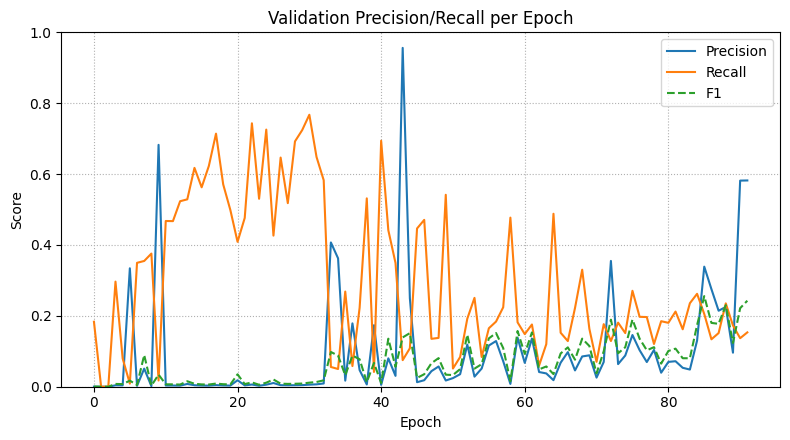

In [13]:
%matplotlib inline
run_dir = Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\runs\exercise_v2baseline")
df = pd.read_csv(run_dir / "results.csv")

p_col = next(c for c in df.columns if "metrics/precision" in c)  # 'metrics/precision(B)'
r_col = next(c for c in df.columns if "metrics/recall" in c)     # 'metrics/recall(B)'

epochs = np.arange(len(df))
p = df[p_col].astype(float)
r = df[r_col].astype(float)
f1 = (2 * p * r / (p + r).replace(0, np.nan)).fillna(0.0)

fig = plt.figure(figsize=(8, 4.5))
plt.plot(epochs, p, label="Precision")
plt.plot(epochs, r, label="Recall")
plt.plot(epochs, f1, linestyle="--", label="F1")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.ylim(0, 1)
plt.title("Validation Precision/Recall per Epoch")
plt.grid(True, linestyle=":")
plt.legend(); plt.tight_layout()

# show first...
plt.show()

# ...then save to your run folder
fig.savefig(run_dir / "precision_recall_f1_per_epoch.png", dpi=200)

In [11]:
RUN_NAME = "v2_best"
BEST_V1 = r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\runs\exercise_v1\weights\best.pt"

model = YOLO(BEST_V1)  
results = model.train(
    data=str(V2_YAML),
    imgsz=896,
    rect=True,
    epochs=150,
    batch=8,
    cache="ram",
    device=0,
    workers=2,
    # augmentations
    fliplr=0.5, flipud=0.0,
    degrees=7.0, translate=0.04, scale=0.5, shear=3.0, perspective=0.0,
    mosaic=0.15, mixup=0.0, copy_paste=0.0,
    close_mosaic=10,
    optimizer="AdamW",
    cos_lr=True, lr0=0.004, patience=30,
    project="runs", name="exercise_v2best"
)

# Evaluate on V2 val/test
BEST_V2 = rf"runs/exercise_v2best/weights/best.pt"
m = YOLO(BEST_V2)
metrics = m.val(data=V2_YAML)
print(f"[{RUN_NAME}] mAP50={metrics.box.map50:.3f}  mAP50-95={metrics.box.map:.3f}")

New https://pypi.org/project/ultralytics/8.3.226 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v2\data.yaml, degrees=7.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=896, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.004, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, 

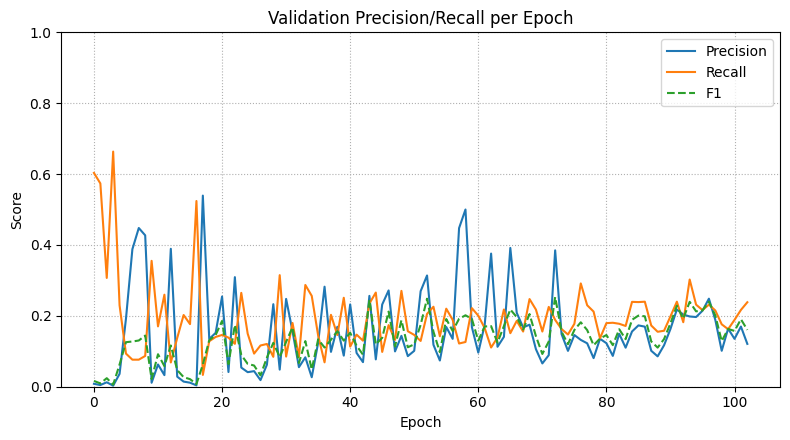

In [15]:
%matplotlib inline
run_dir = Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\runs\exercise_v2best")
df = pd.read_csv(run_dir / "results.csv")

p_col = next(c for c in df.columns if "metrics/precision" in c)  # 'metrics/precision(B)'
r_col = next(c for c in df.columns if "metrics/recall" in c)     # 'metrics/recall(B)'

epochs = np.arange(len(df))
p = df[p_col].astype(float)
r = df[r_col].astype(float)
f1 = (2 * p * r / (p + r).replace(0, np.nan)).fillna(0.0)

fig = plt.figure(figsize=(8, 4.5))
plt.plot(epochs, p, label="Precision")
plt.plot(epochs, r, label="Recall")
plt.plot(epochs, f1, linestyle="--", label="F1")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.ylim(0, 1)
plt.title("Validation Precision/Recall per Epoch")
plt.grid(True, linestyle=":")
plt.legend(); plt.tight_layout()

# show first...
plt.show()

# ...then save to your run folder
fig.savefig(run_dir / "precision_recall_f1_per_epoch.png", dpi=200)

In [ ]:
BASE_PT = rf"runs/exercise_v2baseline/weights/best.pt"
BEST_PT = rf"runs/exercise_v2best/weights/best.pt"

def load_class_names(yaml_path):
    with open(yaml_path, "r", encoding="utf-8") as f:
        y = yaml.safe_load(f)
    if isinstance(y.get("names"), list):
        return y["names"]
    return [y["names"][i] for i in range(len(y["names"]))]

NAMES = load_class_names(V2_YAML)

def eval_model(weights_path, yaml_path):
    y = YOLO(weights_path)
    metrics = y.val(data=yaml_path, verbose=False, plots=False)
    # overall
    out = {
        "mAP50": float(metrics.box.map50),
        "mAP50-95": float(metrics.box.map),
    }
    # per-class (Ultralytics reliably exposes per-class mAP50-95 as metrics.box.maps)
    per_ap5095 = list(metrics.box.maps)
    # try to fetch per-class AP50 if available on your version; else None
    per_ap50 = getattr(metrics.box, "maps50", None)
    if per_ap50 is not None:
        per_ap50 = list(per_ap50)
    return out, per_ap50, per_ap5095

# ---- run evals
overall_base, ap50_base, ap5095_base = eval_model(BASE_PT, V2_YAML)
overall_best, ap50_best, ap5095_best = eval_model(BEST_PT, V2_YAML)

# 1) One-glance comparison table
df_overall = pd.DataFrame([
    {"Model":"V2 baseline (COCO init)", **overall_base},
    {"Model":"V2 best (warm-start from V1)", **overall_best},
])

# 2) Per-class table (uses AP50 if available; otherwise mAP50-95). Also compute deltas.
def per_class_df(names, base50, best50, base5095, best5095):
    rows = []
    for i, cls in enumerate(names):
        row = {"Class": cls}
        # AP50 columns (if available)
        if base50 is not None and best50 is not None:
            row["AP50_V2_base"] = round(float(base50[i]), 4)
            row["AP50_V2_best"] = round(float(best50[i]), 4)
            row["Δ AP50"]        = round(row["AP50_V2_best"] - row["AP50_V2_base"], 4)
        # AP50-95 columns (always available)
        row["mAP50-95_V2_base"] = round(float(base5095[i]), 4)
        row["mAP50-95_V2_best"] = round(float(best5095[i]), 4)
        row["Δ mAP50-95"]       = round(row["mAP50-95_V2_best"] - row["mAP50-95_V2_base"], 4)
        rows.append(row)
    # nice sort: largest improvement first by mAP50-95 delta
    return pd.DataFrame(rows).sort_values(by="Δ mAP50-95", ascending=False)

df_perclass = per_class_df(NAMES, ap50_base, ap50_best, ap5095_base, ap5095_best)

def hide_index(styler):
    if hasattr(styler, "hide"):
        return styler.hide(axis="index")
    if hasattr(styler, "hide_index"):
        return styler.hide_index()
    return styler.set_table_styles([
        {"selector": "th.row_heading", "props": [("display", "none")]},
        {"selector": "tbody tr th",    "props": [("display", "none")]}
    ])

def pretty(styler):
    return (hide_index(styler)
            .set_properties(**{"text-align": "center", "padding": "6px 12px"}))

# ---- OVERALL ----
display(pretty(
    df_overall.rename(columns={"mAP50":"mAP@50","mAP50-95":"mAP@[50:95]"})
              .round(3)
              .style
))

# ---- PER-CLASS ----
use_ap50 = "Δ AP50" in df_perclass.columns
cols_gain = (["Class","AP50_V2_base","AP50_V2_best","Δ AP50"] if use_ap50 else ["Class"]) \
            + ["mAP50-95_V2_base","mAP50-95_V2_best","Δ mAP50-95"]

# A) sort by gain
t_gain = df_perclass.sort_values("Δ mAP50-95", ascending=False)[cols_gain].round(3)
display(pretty(t_gain.style))

Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 510.1176.5 MB/s, size: 67.4 KB)
val: Scanning C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v2\valid\labels.cache... 120 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 120/120 119.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.9it/s 2.8s0.2ss
                   all        120        123      0.136      0.176      0.162     0.0641
Speed: 1.2ms preprocess, 9.4ms inference, 0.0ms loss, 0.6ms postprocess per image
Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fa

Model,mAP@50,mAP@[50:95]
V2 baseline (COCO init),0.162000,0.064000
V2 best (warm-start from V1),0.209000,0.065000


Class,mAP50-95_V2_base,mAP50-95_V2_best,Δ mAP50-95
squat,0.054000,0.182000,0.128000
pushup,0.058000,0.171000,0.113000
shoulder_press,0.001000,0.001000,-0.001000
leg_ext,0.012000,0.011000,-0.002000
benchpress,0.019000,0.005000,-0.014000
deadlift,0.240000,0.023000,-0.217000


Class,mAP50-95_V2_base,mAP50-95_V2_best,Δ mAP50-95
benchpress,0.019000,0.005000,-0.014000
deadlift,0.240000,0.023000,-0.217000
leg_ext,0.012000,0.011000,-0.002000
pushup,0.058000,0.171000,0.113000
shoulder_press,0.001000,0.001000,-0.001000
squat,0.054000,0.182000,0.128000


In [ ]:
from ultralytics import YOLO

COMMON = {
    "data": str(V2_YAML), "imgsz": 896, "rect": True,
    "epochs": 80, "patience": 40, "batch": 8,
    "device": 0, "workers": 2, "cache": "ram",
    "optimizer": "AdamW", "cos_lr": True, "lr0": 0.004,
    "seed": 42, "project": "runs/ablation_study"
}
BASE_AUG = {
    "fliplr": 0.5, "flipud": 0.0, "degrees": 5.0, "shear": 2.0,
    "translate": 0.03, "scale": 0.5, "mosaic": 0.10, "mixup": 0.0,
    "copy_paste": 0.0, "close_mosaic": 15
}

def train_one(name, weights, overrides=None):
    args = {**COMMON, **BASE_AUG}
    if overrides: args.update(overrides)   # exactly one knob change
    return YOLO(str(weights)).train(**args, name=name, exist_ok=True)

# Baseline: COCO init + AdamW
r0 = train_one("B0_coco_AdamW", "yolov8s.pt")

# Init ablation: ONLY weights change
r1 = train_one("H1_warmstart_AdamW", BEST_V1)

# H2: Mosaic (ONLY mosaic changes)
r2 = train_one("H2_mosaic", "yolov8s.pt", overrides={"mosaic": 0.25})

# Optimizer ablation (pure): ONLY optimizer changes, LR kept at 0.004
r3 = train_one("H4_opt_SGD_sameLR",  "yolov8s.pt", overrides={"optimizer": "SGD"})
r4 = train_one("H5_opt_Adam_sameLR", "yolov8s.pt", overrides={"optimizer": "Adam"})
    
# Optional practical follow-ups with tuned LR per optimizer
r5 = train_one("H4b_opt_SGD_lr001",  "yolov8s.pt", overrides={"optimizer": "SGD",  "lr0": 0.01,  "momentum": 0.937})
r6 = train_one("H5b_opt_Adam_lr00025","yolov8s.pt", overrides={"optimizer": "Adam", "lr0": 0.0025})

New https://pypi.org/project/ultralytics/8.3.226 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=15, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v1\data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=896, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.004, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mo

In [28]:
runs = {
    "B0_coco_AdamW": r0,
    "H1_warmstart_AdamW": r1,
    "H2_mosaic": r2,
    "H4_opt_SGD_sameLR": r3,
    "H5_opt_Adam_sameLR": r4,
    "H4b_opt_SGD_lr001": r5,
    "H5b_opt_Adam_lr00025": r6,
}

def find_col(df, key):
    # Ultralytics columns often have "(B)" suffix; this finds the right one
    for c in df.columns:
        if key in c: 
            return c
    raise KeyError(f"Column containing '{key}' not found in results.csv")

summary_rows = []
for name, res in runs.items():
    if res is None: 
        continue
    run_dir = Path(res.save_dir)
    csv_path = run_dir / "results.csv"
    if not csv_path.exists():
        print(f"[WARN] missing results.csv for {name} at {csv_path}")
        continue

    df = pd.read_csv(csv_path)

    m_col = find_col(df, "metrics/mAP50-95")
    p_col = find_col(df, "metrics/precision")
    r_col = find_col(df, "metrics/recall")

    best_ep = int(df[m_col].idxmax())
    best_map = float(df.loc[best_ep, m_col])
    best_p   = float(df.loc[best_ep, p_col])
    best_r   = float(df.loc[best_ep, r_col])

    summary_rows.append({
        "run": name,
        "best_epoch": best_ep,
        "mAP50-95": round(best_map, 4),
        "Precision": round(best_p, 4),
        "Recall": round(best_r, 4),
    })

summary = pd.DataFrame(summary_rows).sort_values("mAP50-95", ascending=False).reset_index(drop=True)
summary

,run,best_epoch,mAP50-95,Precision,Recall
0,H4_opt_SGD_sameLR,35,0.4734,0.7986,0.6529
1,H4b_opt_SGD_lr001,48,0.3409,0.6610,0.6368
2,H5b_opt_Adam_lr00025,66,0.0616,0.2792,0.2469
3,H5_opt_Adam_sameLR,23,0.0573,0.0757,0.2417
4,B0_coco_AdamW,42,0.0375,0.7486,0.1245
5,H2_mosaic,42,0.0375,0.7486,0.1245
6,H1_warmstart_AdamW,20,0.0276,0.3624,0.1991


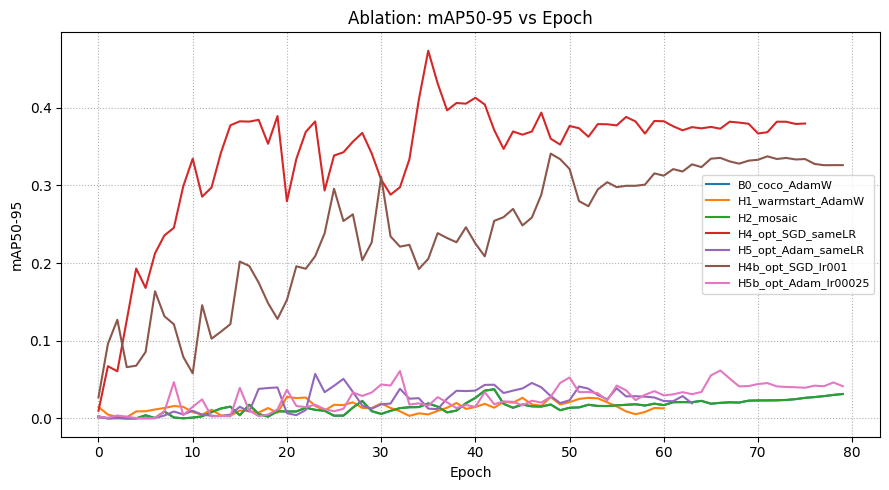

In [29]:
plt.figure(figsize=(9, 5))
for name, res in runs.items():
    if res is None: 
        continue
    run_dir = Path(res.save_dir)
    csv_path = run_dir / "results.csv"
    if not csv_path.exists():
        continue
    df = pd.read_csv(csv_path)
    m_col = [c for c in df.columns if "metrics/mAP50-95" in c][0]
    plt.plot(np.arange(len(df)), df[m_col].astype(float), label=name)

plt.xlabel("Epoch"); plt.ylabel("mAP50-95")
plt.title("Ablation: mAP50-95 vs Epoch")
plt.grid(True, linestyle=":")
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig(Path("runs/ablation_study/mAP_curves.png"), dpi=200)
plt.show()

In [33]:
BEST_V2AB = dict(
    data=str(V2_YAML),
    imgsz=896, rect=True,
    epochs=150, patience=40,
    batch=8, device=0, workers=2, cache="ram",
    optimizer="SGD", momentum=0.937,
    cos_lr=True, lr0=0.004,
    seed=42,
    # same mild augs
    fliplr=0.5, flipud=0.0, degrees=5.0, shear=2.0,
    translate=0.03, scale=0.5, mosaic=0.10, mixup=0.0,
    copy_paste=0.0, close_mosaic=15,
    project="runs", name="exercise_final_sgd", exist_ok=True
)

model = YOLO("yolov8s.pt")
results = model.train(**BEST_V2AB)

New https://pypi.org/project/ultralytics/8.3.226 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=15, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v2\data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=896, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.004, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, m

In [34]:
metrics = model.val(data=str(V2_YAML))
print(f"mAP50={metrics.box.map50:.3f}  mAP50-95={metrics.box.map:.3f}")

Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 122.031.9 MB/s, size: 59.5 KB)
val: Scanning C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v2\valid\labels.cache... 120 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 120/120 120.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.1it/s 3.8s0.2ss
                   all        120        123      0.644      0.725      0.729      0.434
            benchpress         19         23      0.565      0.826      0.732      0.453
              deadlift         20         20      0.709          1      0.898      0.608
               leg_ext         20         20      0.773        0.9      0.905      0.585
           

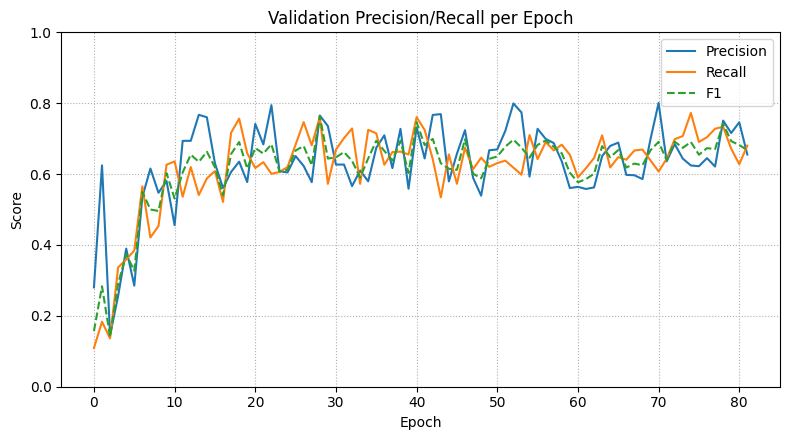

In [35]:
%matplotlib inline
run_dir = Path(results.save_dir)  # e.g. runs/detect/exercise_v1
df = pd.read_csv(run_dir / "results.csv")

p_col = next(c for c in df.columns if "metrics/precision" in c)  # 'metrics/precision(B)'
r_col = next(c for c in df.columns if "metrics/recall" in c)     # 'metrics/recall(B)'

epochs = np.arange(len(df))
p = df[p_col].astype(float)
r = df[r_col].astype(float)
f1 = (2 * p * r / (p + r).replace(0, np.nan)).fillna(0.0)

fig = plt.figure(figsize=(8, 4.5))
plt.plot(epochs, p, label="Precision")
plt.plot(epochs, r, label="Recall")
plt.plot(epochs, f1, linestyle="--", label="F1")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.ylim(0, 1)
plt.title("Validation Precision/Recall per Epoch")
plt.grid(True, linestyle=":")
plt.legend(); plt.tight_layout()

# show first...
plt.show()

# ...then save to your run folder
fig.savefig(run_dir / "precision_recall_f1_per_epoch.png", dpi=200)

Active Learning v3

In [36]:
# --- config you change per round ---
ROUND = "v3" 
ROOT = Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Split_Dataset")

# use your latest trained weights for pseudo-labels (v2 best)
WEIGHTS = ROOT.parent / "runs" / "exercise_final_sgd" / "weights" / "best.pt"
if not WEIGHTS.exists():
    WEIGHTS = ROOT.parent / "runs" / "exercise_v1" / "weights" / "best.pt"
if not WEIGHTS.exists():
    WEIGHTS = Path("yolov8s.pt")

N_TRAIN_PER_CLASS = 40
N_VAL_PER_CLASS   = 10

SEED = 42
CONF, IOU, IMGSZ = 0.50, 0.40, 896
MAXDET = 6

IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp",
            ".JPG",".JPEG",".PNG",".BMP",".TIF",".TIFF",".WEBP"}

# --- paths ---
TRAIN_EXIST = ROOT / "images" / "train"
VAL_EXIST   = ROOT / "images" / "val"
POOL_A      = ROOT / "pool_dataset"
POOL_B      = ROOT / "pool_dataset_cz"

OUT         = ROOT / ROUND
OUT_IMG_T   = OUT / "images" / "train"
OUT_IMG_V   = OUT / "images" / "val"
OUT_LAB_T   = OUT / "labels" / "train"
OUT_LAB_V   = OUT / "labels" / "val"
for d in [OUT_IMG_T, OUT_IMG_V, OUT_LAB_T, OUT_LAB_V]:
    d.mkdir(parents=True, exist_ok=True)

# --- helpers (same as your v2 script) ---
def list_imgs(d: Path):
    return [p for p in d.iterdir() if p.is_file() and p.suffix in IMG_EXTS]

def stems_in(d: Path):
    return {p.stem for p in d.rglob("*") if p.suffix in IMG_EXTS}

# avoid overlap with existing splits
ban_stems = set()
ban_stems |= stems_in(TRAIN_EXIST) if TRAIN_EXIST.exists() else set()
ban_stems |= stems_in(VAL_EXIST)   if VAL_EXIST.exists()   else set()

# also avoid reusing picks from previous rounds (e.g., v2) if not yet merged
PREV_ROUNDS = [ROOT / "v2"]   # add more if you have v1, v2, ...
for R in PREV_ROUNDS:
    for sub in ["images/train", "images/val"]:
        d = R / sub
        if d.exists():
            ban_stems |= stems_in(d)

rng = random.Random(SEED)

classes = sorted([x.name for x in POOL_A.iterdir() if x.is_dir()])
assert all((POOL_B / c).exists() for c in classes), "Class folders mismatch between pools."

print("Picking TRAIN from pool_dataset …")
picked_train = pick_and_copy(POOL_A, OUT_IMG_T, N_TRAIN_PER_CLASS, ban_stems)

if N_VAL_PER_CLASS > 0:
    print("\nPicking VAL from pool_dataset_cz …")
    picked_val = pick_and_copy(POOL_B, OUT_IMG_V, N_VAL_PER_CLASS, ban_stems)
else:
    picked_val = []

print(f"\nTotals: train={len(picked_train)}  val={len(picked_val)}")

model = YOLO(str(WEIGHTS))

lab_t_src = predict_into("train", OUT_IMG_T)
materialize_labels(OUT_IMG_T, lab_t_src, OUT_LAB_T)

if N_VAL_PER_CLASS > 0:
    lab_v_src = predict_into("val", OUT_IMG_V)
    materialize_labels(OUT_IMG_V, lab_v_src, OUT_LAB_V)


Picking TRAIN from pool_dataset …
pool_dataset/benchpress       -> 40/40
pool_dataset/deadlift         -> 40/40
pool_dataset/leg_extension    -> 40/40
pool_dataset/pushup           -> 40/40
pool_dataset/shoulder_press   -> 40/40
pool_dataset/squat            -> 40/40

Picking VAL from pool_dataset_cz …
pool_dataset_cz/benchpress       -> 10/10
pool_dataset_cz/deadlift         -> 10/10
pool_dataset_cz/leg_extension    -> 10/10
pool_dataset_cz/pushup           -> 10/10
pool_dataset_cz/shoulder_press   -> 10/10
pool_dataset_cz/squat            -> 10/10

Totals: train=240  val=60

image 1/240 C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Split_Dataset\v3\images\train\bench press_1100001.jpg: 672x896 1 benchpress, 56.8ms
image 2/240 C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Split_Dataset\v3\images\train\bench press_2300031.jpg: 672x896 1 benchpress, 29.3ms
image 3/24

In [3]:
RUN_NAME = "v3_baseline"
V3_YAML =  Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v3\data.yaml")

BASE_V3 = dict(
    data=str(V3_YAML),
    imgsz=896, rect=True,
    epochs=150, patience=40,
    batch=8, device=0, workers=2, cache="ram",
    optimizer="SGD", momentum=0.937,
    cos_lr=True, lr0=0.004,
    seed=42,
    # same mild augs
    fliplr=0.5, flipud=0.0, degrees=5.0, shear=2.0,
    translate=0.03, scale=0.5, mosaic=0.10, mixup=0.0,
    copy_paste=0.0, close_mosaic=15,
    project="runs", name="exercise_v3baseline", exist_ok=True
)

model = YOLO("yolov8s.pt")
results = model.train(**BASE_V3)

New https://pypi.org/project/ultralytics/8.3.226 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=15, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v3\data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=896, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.004, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, m

In [4]:
# Evaluate on V3 val/test
best_pt = rf"runs/exercise_v3baseline/weights/best.pt"
m = YOLO(best_pt)
metrics = m.val(data=V3_YAML)
print(f"[{RUN_NAME}] mAP50={metrics.box.map50:.3f}  mAP50-95={metrics.box.map:.3f}")

Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 455.1231.3 MB/s, size: 59.2 KB)
val: Scanning C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v3\valid\labels.cache... 180 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 180/180  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.2it/s 3.8s0.2s
                   all        180        186       0.76      0.694      0.806      0.484
            benchpress         31         35      0.591      0.857      0.836      0.505
              deadlift         30         32      0.795      0.938      0.956      0.651
               leg_ext         30         30      0.799        0.8      0.879      0.579
                pus

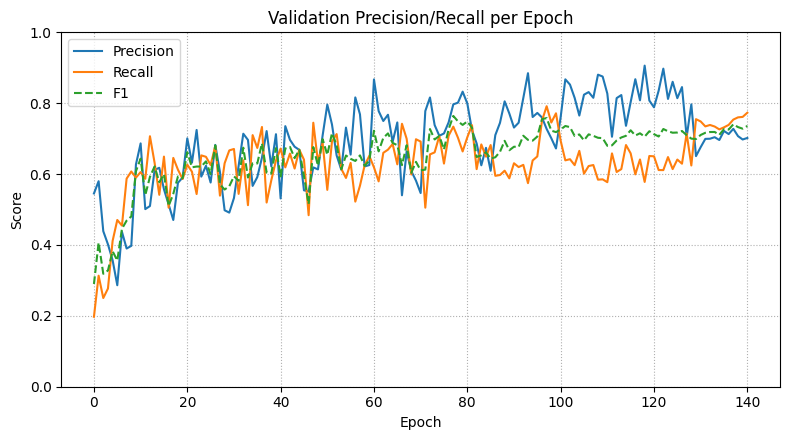

In [6]:
%matplotlib inline
run_dir = Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\runs\exercise_v3baseline")
df = pd.read_csv(run_dir / "results.csv")

p_col = next(c for c in df.columns if "metrics/precision" in c)  # 'metrics/precision(B)'
r_col = next(c for c in df.columns if "metrics/recall" in c)     # 'metrics/recall(B)'

epochs = np.arange(len(df))
p = df[p_col].astype(float)
r = df[r_col].astype(float)
f1 = (2 * p * r / (p + r).replace(0, np.nan)).fillna(0.0)

fig = plt.figure(figsize=(8, 4.5))
plt.plot(epochs, p, label="Precision")
plt.plot(epochs, r, label="Recall")
plt.plot(epochs, f1, linestyle="--", label="F1")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.ylim(0, 1)
plt.title("Validation Precision/Recall per Epoch")
plt.grid(True, linestyle=":")
plt.legend(); plt.tight_layout()

# show first...
plt.show()

# ...then save to your run folder
fig.savefig(run_dir / "precision_recall_f1_per_epoch.png", dpi=200)

In [7]:
RUN_NAME = "v3_best"
V3_YAML =  Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v3\data.yaml")
BEST_V2 = Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\runs\exercise_v2_final_sgd\weights\best.pt")

BEST_V3 = dict(
    data=str(V3_YAML),
    imgsz=896, rect=True,
    epochs=150, patience=40,
    batch=8, device=0, workers=2, cache="ram",
    optimizer="SGD", momentum=0.937,
    cos_lr=True, lr0=0.002,
    seed=42,
    # same mild augs
    fliplr=0.5, flipud=0.0, degrees=5.0, shear=2.0,
    translate=0.03, scale=0.5, mosaic=0.10, mixup=0.0,
    copy_paste=0.0, close_mosaic=15,
    project="runs", name="exercise_v3best", exist_ok=True
)

model = YOLO(BEST_V2)
results = model.train(**BEST_V3)

New https://pypi.org/project/ultralytics/8.3.226 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=15, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v3\data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=896, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, m

In [8]:
# Evaluate on V3 val/test
best_pt = rf"runs/exercise_v3best/weights/best.pt"
m = YOLO(best_pt)
metrics = m.val(data=V3_YAML)
print(f"[{RUN_NAME}] mAP50={metrics.box.map50:.3f}  mAP50-95={metrics.box.map:.3f}")

Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 334.1189.9 MB/s, size: 59.2 KB)
val: Scanning C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v3\valid\labels.cache... 180 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 180/180 180.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 2.9it/s 4.2s0.2s
                   all        180        186       0.77      0.671      0.819      0.495
            benchpress         31         35      0.748      0.857      0.841      0.553
              deadlift         30         32      0.837          1      0.991      0.733
               leg_ext         30         30      0.874      0.967      0.968      0.635
         

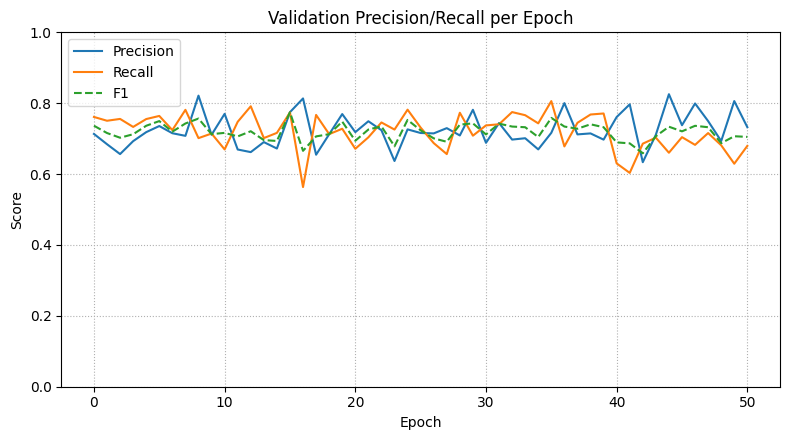

In [9]:
%matplotlib inline
run_dir = Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\runs\exercise_v3best")
df = pd.read_csv(run_dir / "results.csv")

p_col = next(c for c in df.columns if "metrics/precision" in c)  # 'metrics/precision(B)'
r_col = next(c for c in df.columns if "metrics/recall" in c)     # 'metrics/recall(B)'

epochs = np.arange(len(df))
p = df[p_col].astype(float)
r = df[r_col].astype(float)
f1 = (2 * p * r / (p + r).replace(0, np.nan)).fillna(0.0)

fig = plt.figure(figsize=(8, 4.5))
plt.plot(epochs, p, label="Precision")
plt.plot(epochs, r, label="Recall")
plt.plot(epochs, f1, linestyle="--", label="F1")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.ylim(0, 1)
plt.title("Validation Precision/Recall per Epoch")
plt.grid(True, linestyle=":")
plt.legend(); plt.tight_layout()

# show first...
plt.show()

# ...then save to your run folder
fig.savefig(run_dir / "precision_recall_f1_per_epoch.png", dpi=200)

In [3]:
BASE_PT = rf"runs/exercise_v3baseline/weights/best.pt"
BEST_PT = rf"runs/exercise_v3best/weights/best.pt"
V3_YAML =  Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v3\data.yaml")
BEST_V2 = Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\runs\exercise_v2_final_sgd\weights\best.pt")

def load_class_names(yaml_path):
    with open(yaml_path, "r", encoding="utf-8") as f:
        y = yaml.safe_load(f)
    if isinstance(y.get("names"), list):
        return y["names"]
    return [y["names"][i] for i in range(len(y["names"]))]

NAMES = load_class_names(V3_YAML)

def eval_model(weights_path, yaml_path):
    y = YOLO(weights_path)
    metrics = y.val(data=yaml_path, verbose=False, plots=False)
    # overall
    out = {
        "mAP50": float(metrics.box.map50),
        "mAP50-95": float(metrics.box.map),
    }
    # per-class (Ultralytics reliably exposes per-class mAP50-95 as metrics.box.maps)
    per_ap5095 = list(metrics.box.maps)
    # try to fetch per-class AP50 if available on your version; else None
    per_ap50 = getattr(metrics.box, "maps50", None)
    if per_ap50 is not None:
        per_ap50 = list(per_ap50)
    return out, per_ap50, per_ap5095

# ---- run evals
overall_base, ap50_base, ap5095_base = eval_model(BASE_PT, V3_YAML)
overall_best, ap50_best, ap5095_best = eval_model(BEST_PT, V3_YAML)

# 1) One-glance comparison table
df_overall = pd.DataFrame([
    {"Model":"V3 baseline (COCO init)", **overall_base},
    {"Model":"V3 best (warm-start from V2)", **overall_best},
])

# 2) Per-class table (uses AP50 if available; otherwise mAP50-95). Also compute deltas.
def per_class_df(names, base50, best50, base5095, best5095):
    rows = []
    for i, cls in enumerate(names):
        row = {"Class": cls}
        # AP50 columns (if available)
        if base50 is not None and best50 is not None:
            row["AP50_V3_base"] = round(float(base50[i]), 4)
            row["AP50_V3_best"] = round(float(best50[i]), 4)
            row["Δ AP50"]        = round(row["AP50_V3_best"] - row["AP50_V3_base"], 4)
        # AP50-95 columns (always available)
        row["mAP50-95_V3_base"] = round(float(base5095[i]), 4)
        row["mAP50-95_V3_best"] = round(float(best5095[i]), 4)
        row["Δ mAP50-95"]       = round(row["mAP50-95_V3_best"] - row["mAP50-95_V3_base"], 4)
        rows.append(row)
    # nice sort: largest improvement first by mAP50-95 delta
    return pd.DataFrame(rows).sort_values(by="Δ mAP50-95", ascending=False)

df_perclass = per_class_df(NAMES, ap50_base, ap50_best, ap5095_base, ap5095_best)

def hide_index(styler):
    if hasattr(styler, "hide"):
        return styler.hide(axis="index")
    if hasattr(styler, "hide_index"):
        return styler.hide_index()
    return styler.set_table_styles([
        {"selector": "th.row_heading", "props": [("display", "none")]},
        {"selector": "tbody tr th",    "props": [("display", "none")]}
    ])

def pretty(styler):
    return (hide_index(styler)
            .set_properties(**{"text-align": "center", "padding": "6px 12px"}))

# ---- OVERALL ----
display(pretty(
    df_overall.rename(columns={"mAP50":"mAP@50","mAP50-95":"mAP@[50:95]"})
              .round(3)
              .style
))

# ---- PER-CLASS ----
use_ap50 = "Δ AP50" in df_perclass.columns
cols_gain = (["Class","AP50_V3_base","AP50_V3_best","Δ AP50"] if use_ap50 else ["Class"]) \
            + ["mAP50-95_V3_base","mAP50-95_V3_best","Δ mAP50-95"]

# A) sort by gain
t_gain = df_perclass.sort_values("Δ mAP50-95", ascending=False)[cols_gain].round(3)
display(pretty(t_gain.style))

Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.20.0 ms, read: 6.53.6 MB/s, size: 56.7 KB)
val: Scanning C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v3\valid\labels.cache... 180 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 180/180  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.3it/s 2.8s0.2s
                   all        180        186       0.76      0.694      0.806      0.484
Speed: 1.3ms preprocess, 9.9ms inference, 0.0ms loss, 0.6ms postprocess per image
Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image acce

Model,mAP@50,mAP@[50:95]
V3 baseline (COCO init),0.806000,0.484000
V3 best (warm-start from V2),0.819000,0.495000


Class,mAP50-95_V3_base,mAP50-95_V3_best,Δ mAP50-95
deadlift,0.651000,0.733000,0.082000
leg_ext,0.579000,0.635000,0.056000
benchpress,0.505000,0.553000,0.048000
shoulder_press,0.209000,0.202000,-0.008000
pushup,0.484000,0.443000,-0.040000
squat,0.473000,0.401000,-0.072000


Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 428.9210.2 MB/s, size: 56.7 KB)
val: Scanning C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v3\valid\labels.cache... 180 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 180/180 180.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.3it/s 3.6s0.3s
                   all        180        186       0.77      0.671      0.819      0.495
            benchpress         31         35      0.748      0.857      0.841      0.553
              deadlift         30         32      0.837          1      0.991      0.733
               leg_ext         30         30      0.874      0.967      0.968      0.635
         

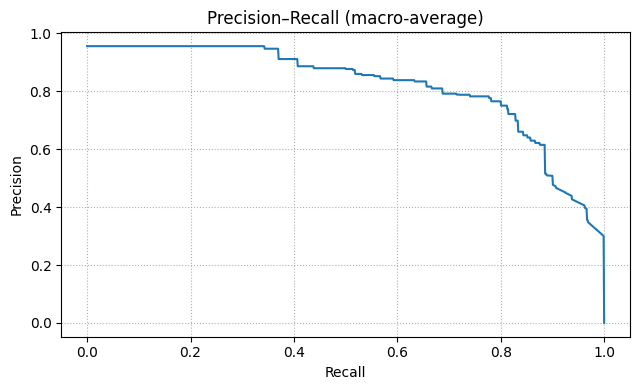

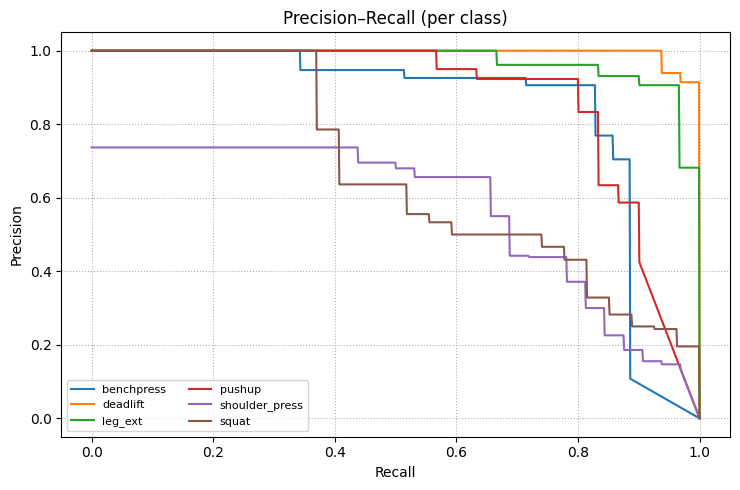

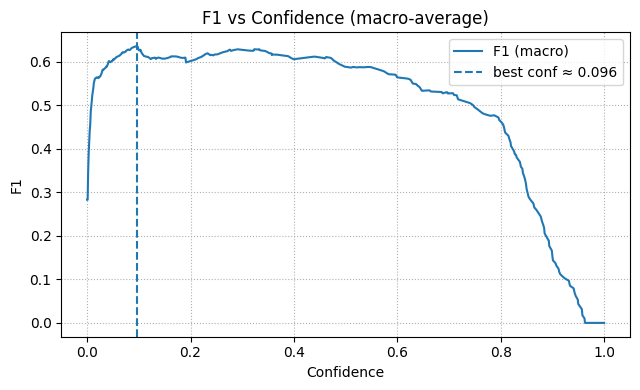

Recommended global conf (F1-max, macro): 0.096  (F1=0.636)


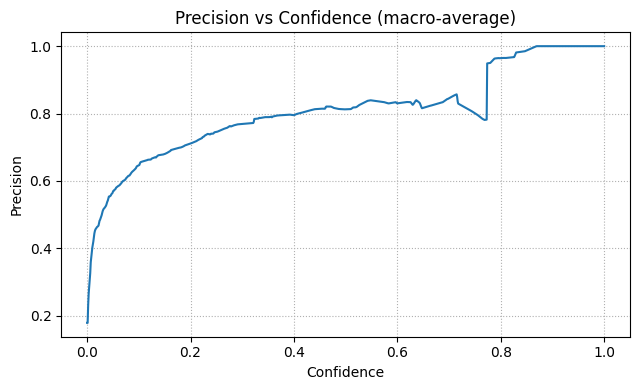

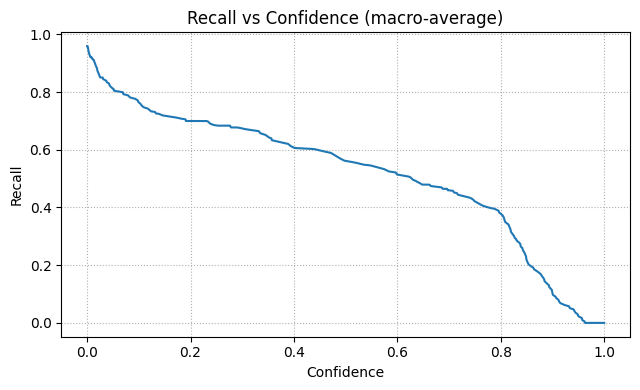

Saved plots in: C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\runs\detect\val27


In [10]:
%matplotlib inline

# --- run val and set dirs ---
v = YOLO(str(BEST_PT)).val(data=str(V3_YAML), imgsz=896, plots=True, workers=0)
run_dir = Path(v.save_dir)
run_dir.mkdir(parents=True, exist_ok=True)

# --- load class names for legends ---
with open(V3_YAML, "r", encoding="utf-8") as f:
    names = yaml.safe_load(f).get("names", [])
if isinstance(names, dict):
    # if dict {id:name}, convert to list in id order
    names = [names[i] for i in range(len(names))]
num_classes = len(names) if names else None

def find_curve_index(v, substr):
    return next(i for i, k in enumerate(v.curves) if substr in k)

def extract_xy_matrix(v, name_substr):
    """Return x: (N,), y_mat: (C, N) where C=num_classes or 1 if already averaged."""
    i = find_curve_index(v, name_substr)
    item = v.curves_results[i]
    x = np.asarray(item[0], dtype=float)
    y = np.asarray(item[1])
    # If y is (N,), promote to (1, N) for uniform handling
    if y.ndim == 1:
        y_mat = y[None, :].astype(float)
    elif y.ndim == 2:
        y_mat = y.astype(float)
    else:
        # fallback: try first two entries
        y_mat = np.asarray(item[1], dtype=float)
        if y_mat.ndim == 1:
            y_mat = y_mat[None, :]
    return x, y_mat

def plot_xy(title, x, y, xlabel, ylabel, fname):
    fig = plt.figure(figsize=(6.5, 4))
    plt.plot(x, y)
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title)
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    fig.savefig(run_dir / fname, dpi=200)
    plt.show(); plt.close(fig)

# 1) Precision–Recall (macro-average across classes)
xr, y_pr_mat = extract_xy_matrix(v, "Precision-Recall")
y_pr_mean = y_pr_mat.mean(axis=0)
plot_xy("Precision–Recall (macro-average)", xr, y_pr_mean, "Recall", "Precision", "pr_curve_mean.png")

# Optional: per-class PR curves
if y_pr_mat.shape[0] > 1:
    fig = plt.figure(figsize=(7.5, 5))
    for ci in range(y_pr_mat.shape[0]):
        label = names[ci] if names and ci < len(names) else f"class {ci}"
        plt.plot(xr, y_pr_mat[ci], label=label)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall (per class)")
    plt.grid(True, linestyle=":"); plt.legend(fontsize=8, ncol=2)
    plt.tight_layout()
    fig.savefig(run_dir / "pr_curve_per_class.png", dpi=200)
    plt.show(); plt.close(fig)

# 2) F1 vs Confidence (macro-average) + best threshold
xc, y_f1_mat = extract_xy_matrix(v, "F1-Confidence")
y_f1_mean = y_f1_mat.mean(axis=0)
best_i = int(np.argmax(y_f1_mean))
best_conf, best_f1 = float(xc[best_i]), float(y_f1_mean[best_i])

fig = plt.figure(figsize=(6.5, 4))
plt.plot(xc, y_f1_mean, label="F1 (macro)")
plt.axvline(best_conf, ls="--", label=f"best conf ≈ {best_conf:.3f}")
plt.xlabel("Confidence"); plt.ylabel("F1"); plt.title("F1 vs Confidence (macro-average)")
plt.grid(True, linestyle=":"); plt.legend(); plt.tight_layout()
fig.savefig(run_dir / "f1_vs_conf_mean.png", dpi=200)
plt.show(); plt.close(fig)
print(f"Recommended global conf (F1-max, macro): {best_conf:.3f}  (F1={best_f1:.3f})")

# 3) Precision vs Confidence (macro-average)
xc, y_pconf_mat = extract_xy_matrix(v, "Precision-Confidence")
plot_xy("Precision vs Confidence (macro-average)", xc, y_pconf_mat.mean(axis=0),
        "Confidence", "Precision", "precision_vs_conf_mean.png")

# 4) Recall vs Confidence (macro-average)
xc, y_rconf_mat = extract_xy_matrix(v, "Recall-Confidence")
plot_xy("Recall vs Confidence (macro-average)", xc, y_rconf_mat.mean(axis=0),
        "Confidence", "Recall", "recall_vs_conf_mean.png")

print("Saved plots in:", run_dir)


1) Precision–Recall (macro-average)

The curve hugs the top left for recall ≤ ~0.5 → the model keeps high precision while picking up about half the positives.

Past ~0.6 recall, precision drops steadily; near recall ≈ 1.0, precision falls (normal—capturing everything introduces FPs).

Takeaway: the detector is confident on many easy cases, but pushing recall higher costs precision.

2) Precision–Recall (per class)

Curves near the top-right are your strong classes (e.g., deadlift, leg_ext).

Curves that drop early (precision falls quickly as recall increases) are weaker/ambiguous (in your plot, shoulder_press and squat look worse).

Action: mine/correct more hard examples for the weaker curves and/or raise their deployment threshold.

3) F1 vs Confidence (macro-average)

Peak at conf ≈ 0.096 (F1 ≈ 0.636).

Interpretation: lowering the threshold from typical 0.25–0.5 gives much more recall with only a modest precision hit—your logits are a bit conservative (under-confident).

Deployment starting point: global conf≈0.10. If you want fewer FPs, try 0.15–0.20 (watch recall).

4) Precision vs Confidence / Recall vs Confidence

Precision ↑ monotonically with confidence; recall ↓ monotonically.

The kink around ~0.6–0.7 (precision plot) suggests a small calibration bump—nothing to worry about.

In [ ]:
with open(V3_YAML, "r", encoding="utf-8") as f:
    names = yaml.safe_load(f)["names"]
if isinstance(names, dict):
    names = [names[i] for i in range(len(names))]

# Find the "F1-Confidence" curve, get X (conf) and Y matrix (classes x points)
idx = next(i for i,k in enumerate(v.curves) if "F1-Confidence" in k)
conf_grid = np.asarray(v.curves_results[idx][0], float)         # shape (N,)
F1_mat    = np.asarray(v.curves_results[idx][1], float)         # shape (C, N)

best_idx  = F1_mat.argmax(axis=1)                               # per-class argmax
best_conf = conf_grid[best_idx]                                  # per-class thresholds
best_f1   = F1_mat[np.arange(F1_mat.shape[0]), best_idx]

for i, (c, f) in enumerate(zip(best_conf, best_f1)):
    print(f"{i:>2} {names[i]:<16} conf*={c:.3f}   F1={f:.3f}")

 0 benchpress       conf*=0.497   F1=0.866
 1 deadlift         conf*=0.765   F1=0.968
 2 leg_ext          conf*=0.358   F1=0.935
 3 pushup           conf*=0.015   F1=0.853
 4 shoulder_press   conf*=0.096   F1=0.656
 5 squat            conf*=0.332   F1=0.593


: 

What “per-class conf” means (and how we got it)

Confidence threshold = the cutoff above which a predicted box is kept.

Per-class = a different cutoff for each class (because some classes are naturally scored lower/higher by the model).

How it’s derived: from the F1-vs-Confidence curve for each class on your validation set.

For each confidence value 
𝑐
c along a grid (e.g., 0→1), compute Precision(c) and Recall(c) for that class.

Compute F1(c) = 2·P(c)·R(c) / (P(c)+R(c)).

Pick the c that maximizes F1 → that’s the per-class conf* for that class.

Why do this? A single global threshold forces the same trade-off on all classes. Per-class thresholds let “strong” classes keep higher conf (fewer FPs) while “weak” classes use lower conf (recover recall).